In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch import optim

from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = [15,10]

In [3]:
torch.__version__

'0.4.0'

In [4]:
data = pd.read_csv('./data/digit-recognizer/train.csv')
data = np.array(data)
X = data[:,1:]
y = data[:,0]

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [6]:
class MNIST(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __getitem__(self, index):
        return (torch.from_numpy(X[index]).float()/256, 
                torch.LongTensor(np.array([y[index]])))
    
    def __len__(self):
        return len(self.X)

In [7]:
class SimpleNeuralNet(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.linears = nn.ModuleList([
            nn.Linear(layers[i], layers[i+1]) for i in range(len(layers) - 1)
        ])
        
    def forward(self, x):
        for lin in self.linears:
            lin_x = lin(x)
            x = F.relu(lin_x)
        return F.log_softmax(lin_x, dim=1)

In [8]:
def init_net():
    return SimpleNeuralNet([IMAGE_SIZE, 100, 100, 10])

In [9]:
def test_validation(net):
    total = 0
    correct = 0
    with torch.no_grad():
        for i, batch in enumerate(data_val):
            inputs, labels = Variable(batch[0]), Variable(batch[1])
            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)
            results = (predicted == labels.squeeze(-1))
            correct_batch = results.sum()
            total_batch = len(results)
            total += total_batch
            correct += correct_batch
    print("Accuracy: {}".format(float(correct)/float(total)))

In [10]:
mnist = MNIST(X_train, y_train)
mnist_val = MNIST(X_val, y_val)
data_dl = DataLoader(mnist, batch_size = 256, shuffle=True, num_workers=0)
data_val = DataLoader(mnist_val, batch_size = 256, shuffle=True, num_workers=0)

In [11]:
epochs = 3
criterion = nn.NLLLoss()

In [12]:
## Create architecture
IMAGE_SIZE = 28 * 28
net = init_net()

# Weight/biases
wbs = [(lin.weight, lin.bias) for lin in net.linears]
losses = []
lr = 1e-3

In [13]:
print("[Epoch, Loss]")
for epoch in range(epochs):
    for i, batch in enumerate(data_dl):
        inputs, labels = Variable(batch[0]), Variable(batch[1])
        outputs = net(inputs)
        
        loss = criterion(outputs, labels.squeeze(-1))
        losses.append(loss)
        loss.backward()
        
        for w, b in wbs:
            w.data -= lr * w.grad.data
            b.data -= lr * b.grad.data
            w.grad.data.zero_()
            b.grad.data.zero_()
    print("[{}, {}]".format(epoch, loss.data))

[Epoch, Loss]
[0, 2.3061561584472656]
[1, 2.297330379486084]
[2, 2.2804336547851562]


In [14]:
sgd_losses = [(l.data.numpy()) for l in losses]
sgd_log_losses_ = [np.log(l) for l in sgd_losses]

Text(0.5,1,'Vanilla SGD')

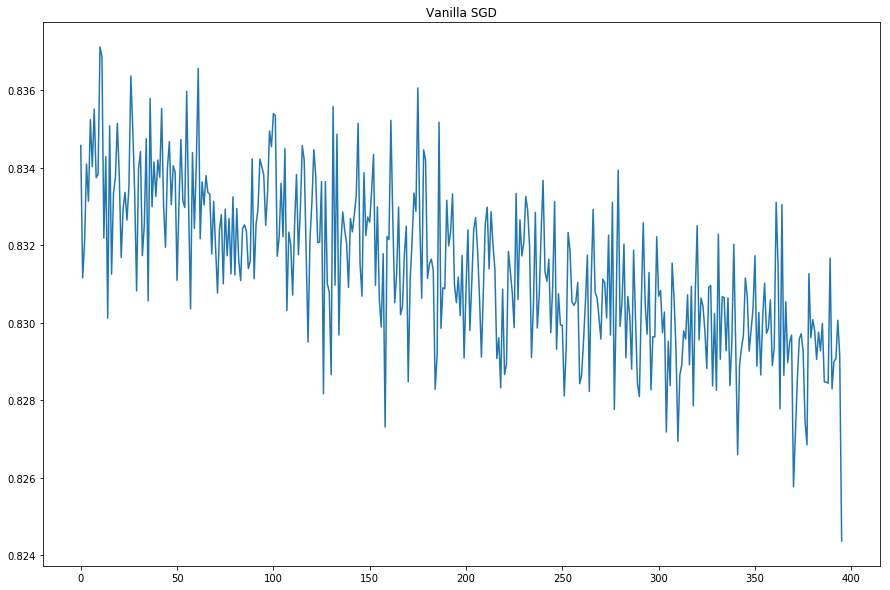

In [15]:
plt.plot(sgd_log_losses_)
plt.title("Vanilla SGD")

## Adding momentum

We can greatly improve neural net performance by reducing variance in the gradient.
We do so through a linear interpolocation between past gradients and the current one.

https://stats.stackexchange.com/questions/179915/whats-the-difference-between-momentum-based-gradient-descent-and-nesterovs-ac

In [16]:
net = init_net()
wbs = [(lin.weight, lin.bias) for lin in net.linears]
losses = []

# parameters
lr = 1e-3
rho = .9
epochs = 3

# momentum trackers
weight_v_prev = [0 for i in range(len(wbs))]
bias_v_prev = [0 for i in range(len(wbs))]

In [17]:
print("[Epoch, Loss]")
for epoch in range(epochs):
    for i, batch in enumerate(data_dl):
        inputs, labels = Variable(batch[0]), Variable(batch[1])
        outputs = net(inputs)
        
        loss = criterion(outputs, labels.squeeze(-1))
        losses.append(loss)
        loss.backward()
        
        for i, wb in enumerate(wbs):
            w = wb[0]
            b = wb[1]
            weight_v_curr = rho * weight_v_prev[i] + lr * w.grad.data
            bias_v_curr = rho * bias_v_prev[i] + lr * b.grad.data
            
            weight_v_prev[i] = weight_v_curr
            bias_v_prev[i] = bias_v_curr
            w.data -= weight_v_curr
            b.data -= bias_v_curr
            
            w.grad.data.zero_()
            b.grad.data.zero_()
    print("[{}, {}]".format(epoch, loss.data))

[Epoch, Loss]
[0, 2.288593053817749]
[1, 2.2313218116760254]
[2, 2.1103858947753906]


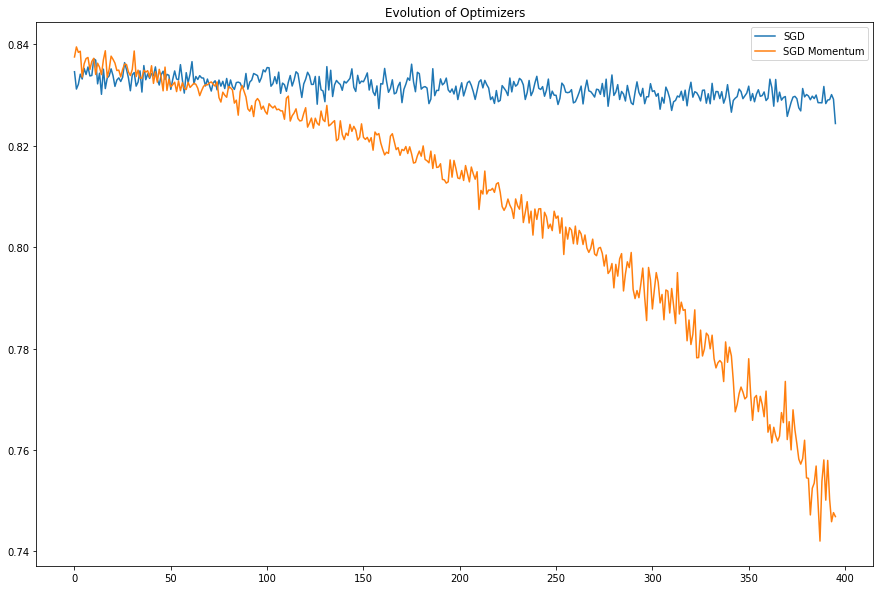

In [18]:
sgdmom_losses_ = [(l.data.numpy()) for l in losses]
sgdmom_log_losses_ = [np.log(l) for l in sgdmom_losses_]

plt.plot(sgd_log_losses_)
plt.plot(sgdmom_log_losses_)
title = plt.title("Evolution of Optimizers")
plt.legend(('SGD', 'SGD Momentum'))   

## Nesterov's Optimizer

There is extra value in reducing the noise/variance in the gradients. We can do
so by peeking into what a gradiend will be in the future and adjusting for it

In [19]:
### init architecture
net = init_net()

### get weight, bias objects
wbs = [(lin.weight, lin.bias) for lin in net.linears]

### keep track of training loss
losses = []

###params
lr = 1e-3
rho = 0.9
weight_v_prev = [0 for i in range(len(wbs))] # initialize momentum term
bias_v_prev = [0 for i in range(len(wbs))] # initialize momentum term

epochs = 3

In [20]:
print("[Epoch, Loss]")
for epoch in range(epochs):
    for n, batch in enumerate(data_dl):
        inputs, labels = batch
        inputs, labels = Variable(batch[0]), Variable(batch[1])
        outputs = net(inputs)
        
        # compute loss
        loss = criterion(outputs, labels.squeeze(-1))
        losses.append(loss)
        
        # update weights 
        for i, wb in enumerate(wbs):
            w = wb[0]
            b = wb[1]
            
            w_save = w.data
            b_save = b.data
            # Update the weights
            # peek into the 'future' to see the next gradient
            w.data -= rho * weight_v_prev[i]
            peek_outputs = net(inputs)
            peek_loss = criterion(outputs, labels.squeeze(-1))
            peek_loss.backward(retain_graph=True)
            peek_grad = w.grad.data
                     
            weight_v_new = rho * weight_v_prev[i] + lr * peek_grad
            weight_v_prev[i] = weight_v_new
            w.data = w_save
            
            # final update
            w.data -= weight_v_new
            net.zero_grad()
            
            
            # update biases
            # peek into the 'future' to see the next gradient
            b_original = b.data
            b.data -= rho * bias_v_prev[i]
            
            # calculate loss and gradient, to see how would it be
            peek_outputs = net(inputs)
            peek_loss = criterion(outputs, labels.squeeze(-1))
            peek_loss.backward(retain_graph=True)
            peek_grad = b.grad.data
            
            bias_v_new = rho * bias_v_prev[i] + lr * peek_grad
            bias_v_prev[i] = bias_v_new
            b.data = b_save
            b.data -= bias_v_new
            
            # zero all gradients
            net.zero_grad()
    print("[{}, {}]".format(epoch, loss.data))

[Epoch, Loss]
[0, 2.2372100353240967]
[1, 1.8932700157165527]
[2, 1.1808043718338013]


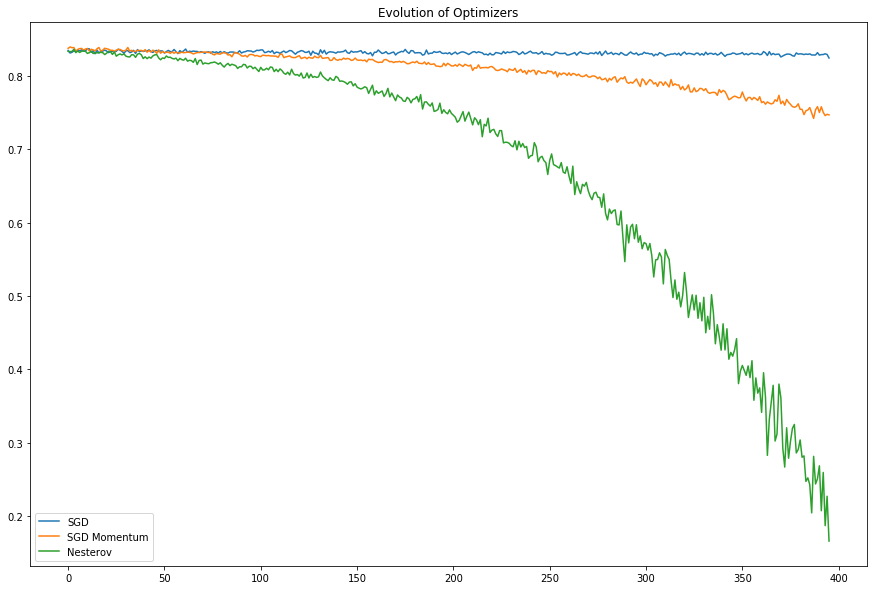

In [21]:
nesterov_losses_ = [(l.data.numpy()) for l in losses]
nesterov_log_losses_ = [np.log(l) for l in nesterov_losses_]
plt.plot(sgd_log_losses_)
plt.plot(sgdmom_log_losses_)
plt.plot(nesterov_log_losses_)
title = plt.title("Evolution of Optimizers")
plt.legend(('SGD', 'SGD Momentum', 'Nesterov'))

## Adagrad

Adaptive subgradient methods is a wonderful way to mitigate fine-tuning learning
rates. When the gradient is high, their effective learning rate is reduced, while
weights with smaller updatess (sparse) will have their learning rate increased.

https://xcorr.net/2014/01/23/adagrad-eliminating-learning-rates-in-stochastic-gradient-descent/

In [22]:
net = init_net()
wbs = [(lin.weight, lin.bias) for lin in net.linears]
losses = []

# params
lr = .001
grads_squared = [[torch.zeros(wb[0].size()), torch.zeros(wb[1].size())] for wb in wbs]
noise = 1e-8

epochs = 3

In [23]:
### Training 
print("[Epoch, Loss]")
for epoch in range(epochs):
    for i, batch in enumerate(data_dl):
        inputs, labels = Variable(batch[0]), Variable(batch[1])
        outputs = net(inputs)
        
        # compute loss and gradients
        loss = criterion(outputs, labels.squeeze(-1))
        losses.append(loss)
        loss.backward()
        
        # update weights 
        for i, wb in enumerate(wbs):
            w = wb[0]
            b = wb[1]
            
            w.data -= lr*(w.grad.data / torch.sqrt(grads_squared[i][0] + noise))
            b.data -= lr*(b.grad.data / torch.sqrt(grads_squared[i][1] + noise))
            
            grads_squared[i][0] += w.grad.data*w.grad.data
            grads_squared[i][1] += b.grad.data*b.grad.data
            
            # zero the gradients
            w.grad.data.zero_()
            b.grad.data.zero_()
    print("[{}, {}]".format(epoch, loss.data))

[Epoch, Loss]
[0, 0.8439731001853943]
[1, 0.5521501302719116]
[2, 0.589593768119812]


In [24]:
adagrad_losses_ = [(l.data.numpy()) for l in losses]
adagrad_log_losses_ = [np.log(l) for l in adagrad_losses_]

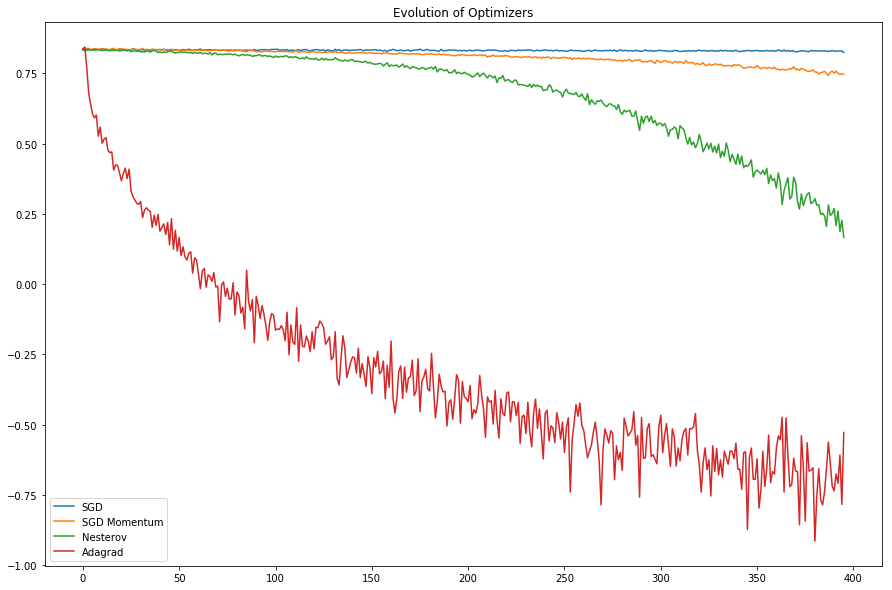

In [25]:
plt.plot(sgd_log_losses_)
plt.plot(sgdmom_log_losses_)
plt.plot(nesterov_log_losses_)
plt.plot(adagrad_log_losses_)
title = plt.title("Evolution of Optimizers")
plt.legend(('SGD', 'SGD Momentum', 'Nesterov', 'Adagrad'))

In [26]:
test_validation(net)

Accuracy: 0.8789285714285714


## AdaMax
http://ruder.io/optimizing-gradient-descent/index.html#adam

The Adam optimizer encodes both an exponentially decaying average
of past squared gradients and an exponentially decaying average
fo past gradients (momentum!). 

`beta_1` dictates the linear interpolation of the momentum, or in
other words the first moment

`beta_2` dictates the linear interpolation of the variance

In [27]:
net = init_net()
wbs = [(lin.weight, lin.bias) for lin in net.linears]
losses = []

lr = 1e-3
beta1 = .9
beta2 = .999
noise = 1e-22

m_v_prevs = [
    [
        [torch.zeros_like(wb[0]).data, torch.zeros_like(wb[0]).data],
        [torch.zeros_like(wb[1]).data, torch.zeros_like(wb[1]).data]
    ]
    for wb in wbs
]
epochs = 3
t = 0

In [28]:
print("[Epoch, Loss]")
for epoch in range(epochs):
    for i, batch in enumerate(data_dl):
        t += 1
        inputs, labels = Variable(batch[0]), Variable(batch[1])
        outputs = net(inputs)
        
        loss = criterion(outputs, labels.squeeze(-1))
        losses.append(loss)
        loss.backward()
        
        for i, wb in enumerate(wbs):
            w = wb[0]
            b = wb[1]
            
            # update weight component
            weight_prev_m_v = m_v_prevs[i][0]
            weight_prev_m = weight_prev_m_v[0]
            weight_prev_v = weight_prev_m_v[1]
            
            weight_new_m = beta1 * weight_prev_m + (1 - beta1) * w.grad.data
            weight_new_v = torch.max(beta2 * weight_prev_v, torch.abs(w.grad.data))
            weight_new_m_hat = weight_new_m / (1 - beta1**t)
            
            m_v_prevs[i][0][0] = weight_new_m
            m_v_prevs[i][0][1] = weight_new_v
                
            w.data -= lr * weight_new_m_hat / (weight_new_v + noise)
            
            # update bias component
            bias_prev_m_v = m_v_prevs[i][1]
            bias_prev_m = bias_prev_m_v[0]
            bias_prev_v = bias_prev_m_v[1]
            
            bias_new_m = beta1 * bias_prev_m + (1 - beta1) * b.grad.data
            bias_new_v = torch.max(beta2 * bias_prev_v, torch.abs(b.grad.data))
            bias_new_m_hat = bias_new_m/ (1 - beta1**t)
            
            m_v_prevs[i][1][0] = bias_new_m
            m_v_prevs[i][1][1] = bias_new_v
                
            b.data -= lr * bias_new_m_hat / (bias_new_v + noise)
            
            # zero the gradients
            w.grad.data.zero_()
            b.grad.data.zero_()
    print("[{}, {}]".format(epoch, loss.data))

[Epoch, Loss]
[0, 0.32251882553100586]
[1, 0.29518312215805054]
[2, 0.23761297762393951]


## Testing on the Validation Set

Out of laziness, we we're using the validation set as our test
set. Of course, having 3 sets is the most robust way to verify
a model.

In [29]:
test_validation(net)

Accuracy: 0.9211904761904762


Not bad for a neural net that takes less than 5 seconds to run.
For higher accuracy, we could run more epochs and add
l2 regularization. Pytorch comes in handy for this.

In [30]:
net = init_net()
lr = 1e-3
weight_decay = 1e-3
optimizer = torch.optim.Adamax(
    net.linears.parameters(), lr=lr, weight_decay=weight_decay)
epochs = 32

In [31]:
print("[Epoch, Loss]")
for epoch in range(epochs):
    for i, batch in enumerate(data_dl):
        t += 1
        inputs, labels = Variable(batch[0]), Variable(batch[1])
        outputs = net(inputs)
        
        loss = criterion(outputs, labels.squeeze(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("[{}, {}]".format(epoch, loss.data))

[Epoch, Loss]
[0, 0.3659074008464813]
[1, 0.1926562339067459]
[2, 0.32375824451446533]
[3, 0.29811543226242065]
[4, 0.2327810823917389]
[5, 0.09445592015981674]
[6, 0.309091180562973]
[7, 0.27141743898391724]
[8, 0.24875639379024506]
[9, 0.14963309466838837]
[10, 0.13830621540546417]
[11, 0.12067851424217224]
[12, 0.13107508420944214]
[13, 0.08560620248317719]
[14, 0.1430351436138153]
[15, 0.1008053869009018]
[16, 0.19154420495033264]
[17, 0.09949856251478195]
[18, 0.15040306746959686]
[19, 0.11764185130596161]
[20, 0.13276346027851105]
[21, 0.03186182305216789]
[22, 0.04930371418595314]
[23, 0.03411274030804634]
[24, 0.08064835518598557]
[25, 0.090208038687706]
[26, 0.10588262975215912]
[27, 0.055512685328722]
[28, 0.04727056249976158]
[29, 0.01122098509222269]
[30, 0.08009405434131622]
[31, 0.04267468303442001]


In [32]:
test_validation(net)

Accuracy: 0.9863095238095239
